In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18, resnet50
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
train_size = 0.8

augmentation_list = ['TimeShift', 'Noise', 'TimeMasking', 'FreqMasking', 'TimeRandomSwap']

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

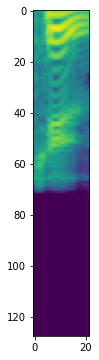

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 4):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def TimeCycleShift(image, max_shift = 4):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def TimeSwapAugmentation(image, max_b = 4):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def TimeReplyMasking(image, max_b = 4):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 4):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(4)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(25)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 25, 4)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)   
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = []):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [15]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, random_augmentation = False, choice_augmentation = False, augmentation_list = [], aug_probs = []):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    flag_probs = False
    
    if len(aug_probs) > 0:
        flag_probs = True
    
    if choice_augmentation:
        frequences = dict()
        for augmentation_name in augmentation_list:
            frequences[augmentation_name] = 0
        aug_type = np.random.choice(augmentation_list)
    
    for epoch in tqdm(range(epochs)):
        if choice_augmentation:
            frequences[aug_type] += 1
        #Train
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            if random_augmentation or choice_augmentation:
                for i in range(len(y)):
                    if random_augmentation:
                        if flag_probs:
                            aug_type = np.random.choice(augmentation_list, p = aug_probs)
                        else:
                            aug_type = np.random.choice(augmentation_list)
                    if np.random.rand() < 0.5:
                        X[i] = augmentation(X[i], mode = aug_type)
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        
        #Validation
        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        # choose augmentation
        if choice_augmentation:
            aug_accuracy = []
            with torch.no_grad():
                for aug in augmentation_list:
                    sum_accuracy = 0
                    cnt_objects = 0
                    for X, y in valid_loader:
                        for i in range(len(y)):
                            X[i] = augmentation(X[i], mode = aug)
                        X = X.to(device)
                        scores = model(X)
                        preds = scores.cpu().detach().argmax(dim=1)
                        accuracy = float((y == preds).float().sum())
                        sum_accuracy += accuracy
                        cnt_objects += len(y)
                    mean_accuracy = sum_accuracy / cnt_objects
                    aug_accuracy.append(mean_accuracy)
            aug_type = augmentation_list[np.argmin(aug_accuracy)]
    
    frequences_probs = []
    print('Accuracy on the validation: ', best_acc)
    if choice_augmentation:
        for aug_type in augmentation_list:
            frequences_probs.append(frequences[aug_type] / float(epochs))
        print('Frequences:', frequences)
    model.load_state_dict(best_model_wts)
    return model, [train_losses, valid_losses, valid_acc], frequences_probs

In [16]:
def evaluate(model, test_loader):
    model.eval()
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)

    mean_accuracy = sum_accuracy / cnt_objects
    print('************************')
    print('Quality of the model')
    print('Accuracy on test:', mean_accuracy)
    return mean_accuracy

In [17]:
no_augmentation_accuracy18 = []
random_сhoice_accuracy18 = []
choice_after_each_epoch_accuracy18 = []
no_augmentation_accuracy50 = []
random_сhoice_accuracy50 = []
choice_after_each_epoch_accuracy50 = []

# Random seed = 1

In [18]:
random_seed = 1

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9690189328743546


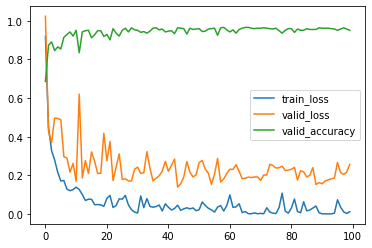

In [19]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 1


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


Accuracy on the validation:  0.9720430107526882
************************
Quality of the model
Accuracy on test: 0.9655765920826161


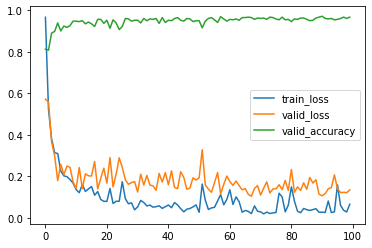

In [20]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 1


100%|██████████| 100/100 [04:33<00:00,  2.74s/it]


Accuracy on the validation:  0.9806451612903225
Frequences: {'TimeShift': 37, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 48, 'TimeRandomSwap': 15}
************************
Quality of the model
Accuracy on test: 0.9724612736660929


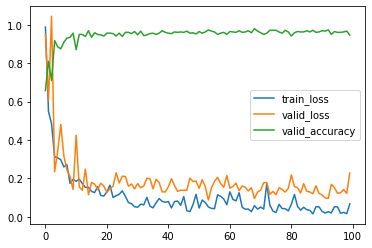

In [21]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [06:13<00:00,  3.73s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.9483648881239243


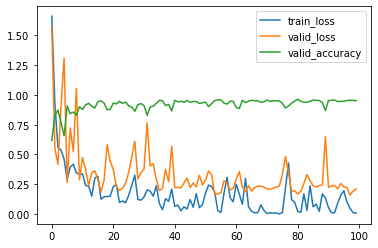

In [22]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 1


100%|██████████| 100/100 [06:32<00:00,  3.93s/it]


Accuracy on the validation:  0.9741935483870968
************************
Quality of the model
Accuracy on test: 0.9672977624784854


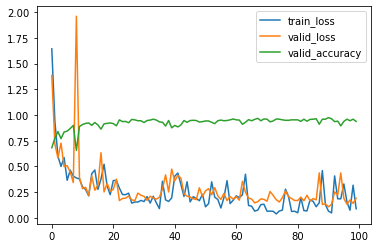

In [23]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 1


100%|██████████| 100/100 [08:41<00:00,  5.21s/it]


Accuracy on the validation:  0.9720430107526882
Frequences: {'TimeShift': 30, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 57, 'TimeRandomSwap': 13}
************************
Quality of the model
Accuracy on test: 0.9621342512908778


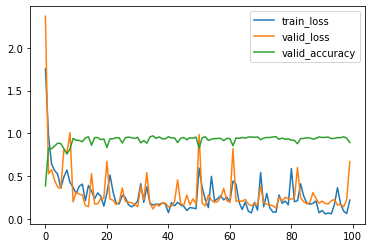

In [24]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 42

In [25]:
random_seed = 42

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.955249569707401


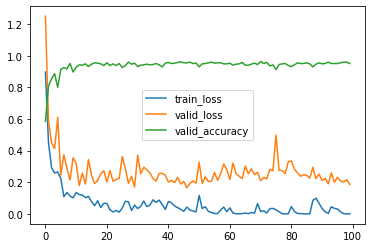

In [26]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 42


100%|██████████| 100/100 [03:22<00:00,  2.02s/it]


Accuracy on the validation:  0.9763440860215054
************************
Quality of the model
Accuracy on test: 0.963855421686747


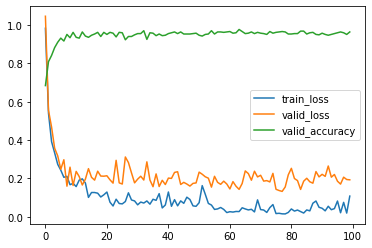

In [27]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 42


100%|██████████| 100/100 [04:34<00:00,  2.75s/it]


Accuracy on the validation:  0.9763440860215054
Frequences: {'TimeShift': 37, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 42, 'TimeRandomSwap': 21}
************************
Quality of the model
Accuracy on test: 0.9604130808950087


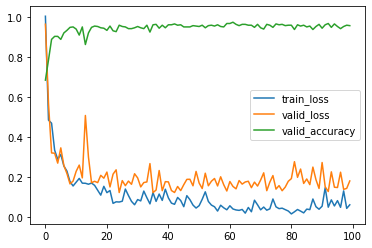

In [28]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [06:17<00:00,  3.77s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.9397590361445783


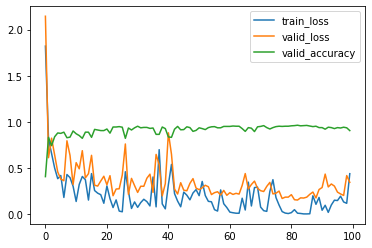

In [29]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 42


100%|██████████| 100/100 [06:36<00:00,  3.96s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9604130808950087


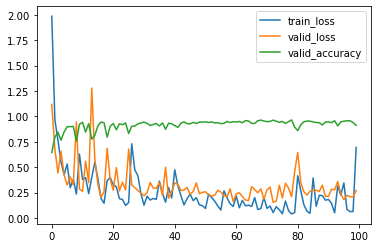

In [30]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 42


100%|██████████| 100/100 [08:44<00:00,  5.24s/it]


Accuracy on the validation:  0.9612903225806452
Frequences: {'TimeShift': 38, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 52, 'TimeRandomSwap': 10}
************************
Quality of the model
Accuracy on test: 0.9621342512908778


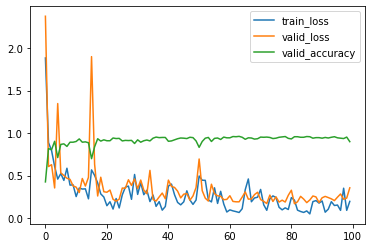

In [31]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 10

In [32]:
random_seed = 10

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.9500860585197934


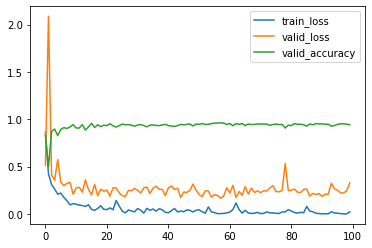

In [33]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 10


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9466437177280551


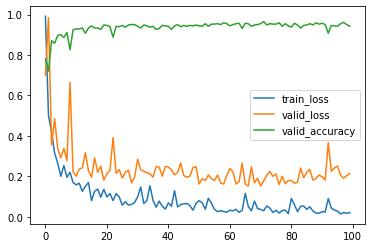

In [34]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 10


100%|██████████| 100/100 [04:36<00:00,  2.77s/it]


Accuracy on the validation:  0.9741935483870968
Frequences: {'TimeShift': 36, 'Noise': 1, 'TimeMasking': 0, 'FreqMasking': 48, 'TimeRandomSwap': 15}
************************
Quality of the model
Accuracy on test: 0.955249569707401


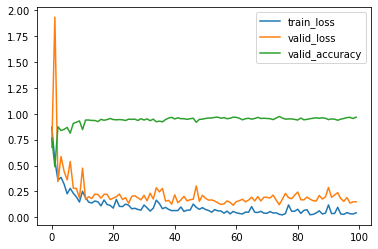

In [35]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [06:20<00:00,  3.80s/it]


Accuracy on the validation:  0.9505376344086022
************************
Quality of the model
Accuracy on test: 0.9483648881239243


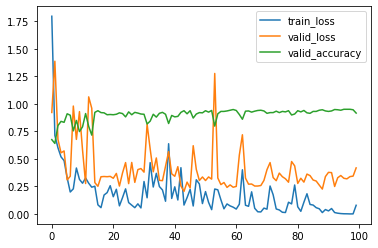

In [36]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 10


100%|██████████| 100/100 [06:35<00:00,  3.96s/it]


Accuracy on the validation:  0.956989247311828
************************
Quality of the model
Accuracy on test: 0.9483648881239243


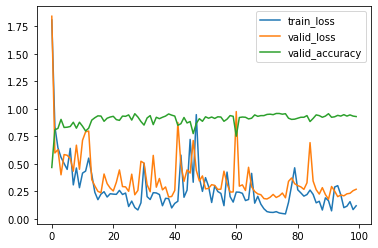

In [37]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 10


100%|██████████| 100/100 [08:42<00:00,  5.22s/it]


Accuracy on the validation:  0.956989247311828
Frequences: {'TimeShift': 27, 'Noise': 1, 'TimeMasking': 0, 'FreqMasking': 56, 'TimeRandomSwap': 16}
************************
Quality of the model
Accuracy on test: 0.9242685025817556


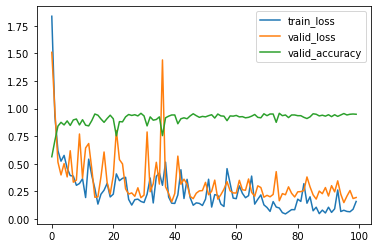

In [38]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 15

In [39]:
random_seed = 15

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


Accuracy on the validation:  0.967741935483871
************************
Quality of the model
Accuracy on test: 0.9621342512908778


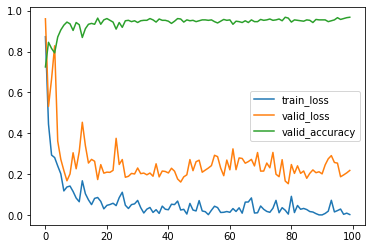

In [40]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 15


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


Accuracy on the validation:  0.9698924731182795
************************
Quality of the model
Accuracy on test: 0.9569707401032702


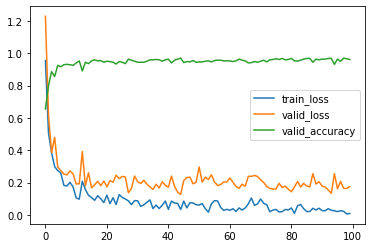

In [41]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 15


100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


Accuracy on the validation:  0.9741935483870968
Frequences: {'TimeShift': 35, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 47, 'TimeRandomSwap': 18}
************************
Quality of the model
Accuracy on test: 0.963855421686747


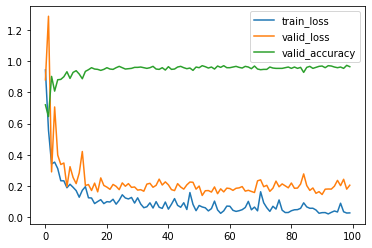

In [42]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [06:15<00:00,  3.76s/it]


Accuracy on the validation:  0.956989247311828
************************
Quality of the model
Accuracy on test: 0.9483648881239243


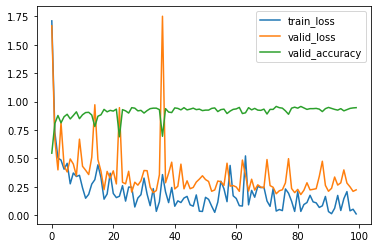

In [43]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 15


100%|██████████| 100/100 [06:31<00:00,  3.92s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9500860585197934


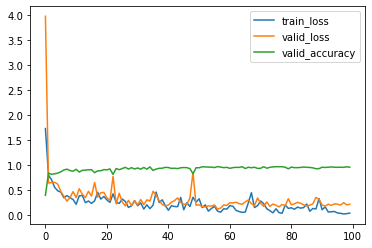

In [44]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 15


100%|██████████| 100/100 [08:40<00:00,  5.20s/it]


Accuracy on the validation:  0.9634408602150538
Frequences: {'TimeShift': 37, 'Noise': 0, 'TimeMasking': 1, 'FreqMasking': 51, 'TimeRandomSwap': 11}
************************
Quality of the model
Accuracy on test: 0.9518072289156626


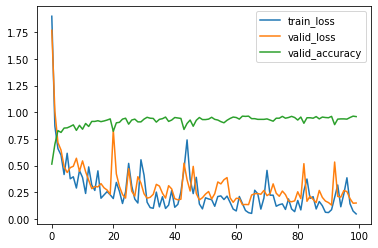

In [45]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 23

In [46]:
random_seed = 23

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


Accuracy on the validation:  0.9698924731182795
************************
Quality of the model
Accuracy on test: 0.9466437177280551


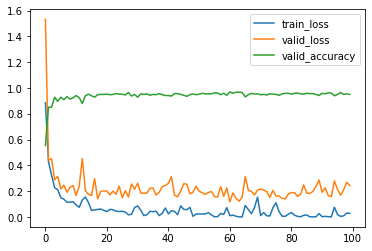

In [47]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 23


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


Accuracy on the validation:  0.9741935483870968
************************
Quality of the model
Accuracy on test: 0.9569707401032702


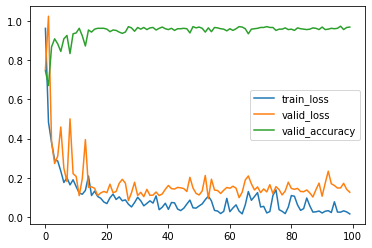

In [48]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 23


100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


Accuracy on the validation:  0.9741935483870968
Frequences: {'TimeShift': 33, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 47, 'TimeRandomSwap': 20}
************************
Quality of the model
Accuracy on test: 0.9500860585197934


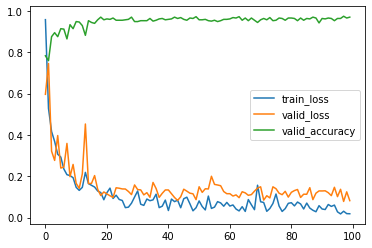

In [49]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [06:14<00:00,  3.75s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9397590361445783


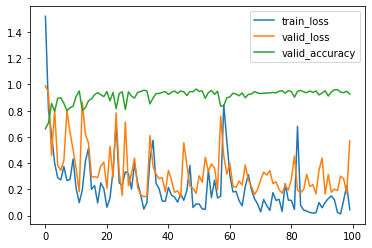

In [50]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 23


100%|██████████| 100/100 [06:33<00:00,  3.94s/it]


Accuracy on the validation:  0.967741935483871
************************
Quality of the model
Accuracy on test: 0.9483648881239243


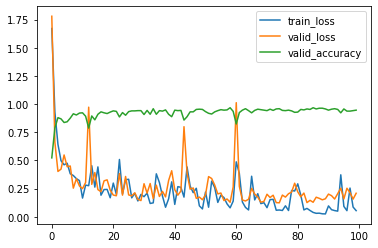

In [51]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 23


100%|██████████| 100/100 [08:43<00:00,  5.24s/it]


Accuracy on the validation:  0.9763440860215054
Frequences: {'TimeShift': 29, 'Noise': 0, 'TimeMasking': 1, 'FreqMasking': 62, 'TimeRandomSwap': 8}
************************
Quality of the model
Accuracy on test: 0.9414802065404475


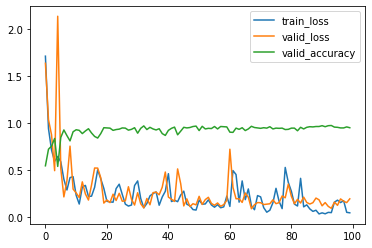

In [52]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Results

In [53]:
print("resnet18")
no_augmentation_accuracy18 = np.array(no_augmentation_accuracy18) * 100
random_сhoice_accuracy18 = np.array(random_сhoice_accuracy18) * 100
choice_after_each_epoch_accuracy18 = np.array(choice_after_each_epoch_accuracy18) * 100
print("No augmentation")
print("mean:", np.mean(no_augmentation_accuracy18))
print("std:", np.std(no_augmentation_accuracy18))
print("Random сhoice")
print("mean:", np.mean(random_сhoice_accuracy18))
print("std:", np.std(random_сhoice_accuracy18))
print("Choice after each epoch")
print("mean:", np.mean(choice_after_each_epoch_accuracy18))
print("std:", np.std(choice_after_each_epoch_accuracy18))

resnet18
No augmentation
mean: 95.66265060240964
std: 0.8102307949011932
Random сhoice
mean: 95.80034423407918
std: 0.6674946447389086
Choice after each epoch
mean: 96.04130808950086
std: 0.7619946169080425


In [54]:
print("resnet50")
no_augmentation_accuracy50 = np.array(no_augmentation_accuracy50) * 100
random_сhoice_accuracy50 = np.array(random_сhoice_accuracy50) * 100
choice_after_each_epoch_accuracy50 = np.array(choice_after_each_epoch_accuracy50) * 100
print("No augmentation")
print("mean:", np.mean(no_augmentation_accuracy50))
print("std:", np.std(no_augmentation_accuracy50))
print("Random сhoice")
print("mean:", np.mean(random_сhoice_accuracy50))
print("std:", np.std(random_сhoice_accuracy50))
print("Choice after each epoch")
print("mean:", np.mean(choice_after_each_epoch_accuracy50))
print("std:", np.std(choice_after_each_epoch_accuracy50))

resnet50
No augmentation
mean: 94.49225473321859
std: 0.4215989230263653
Random сhoice
mean: 95.49053356282272
std: 0.765098477483406
Choice after each epoch
mean: 94.83648881239245
std: 1.4276379589210122
